# Stacked GRU regression

In [6]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
import tensorflow as tf
tf.random.set_seed(0)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import GRU, Dense, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
TRAIN_RANGE = (datetime(1949, 1, 1), datetime(1956, 12, 1))
VALID_RANGE = (datetime(1957, 1, 1), datetime(1958, 12, 1))
TEST_RANGE = (datetime(1959, 1, 1), datetime(1960, 12, 1))
TIMESTEPS = 12  # Input 12 months to predict next month

## 1. Read in dataset

In [10]:
data = pd.read_csv('data/airline-passengers.csv')
data.index = pd.to_datetime(data.Month)  # Set datetime index
data.drop(['Month'], axis=1, inplace=True)

<Axes: title={'center': 'Monthly airline passengers'}, xlabel='Month'>

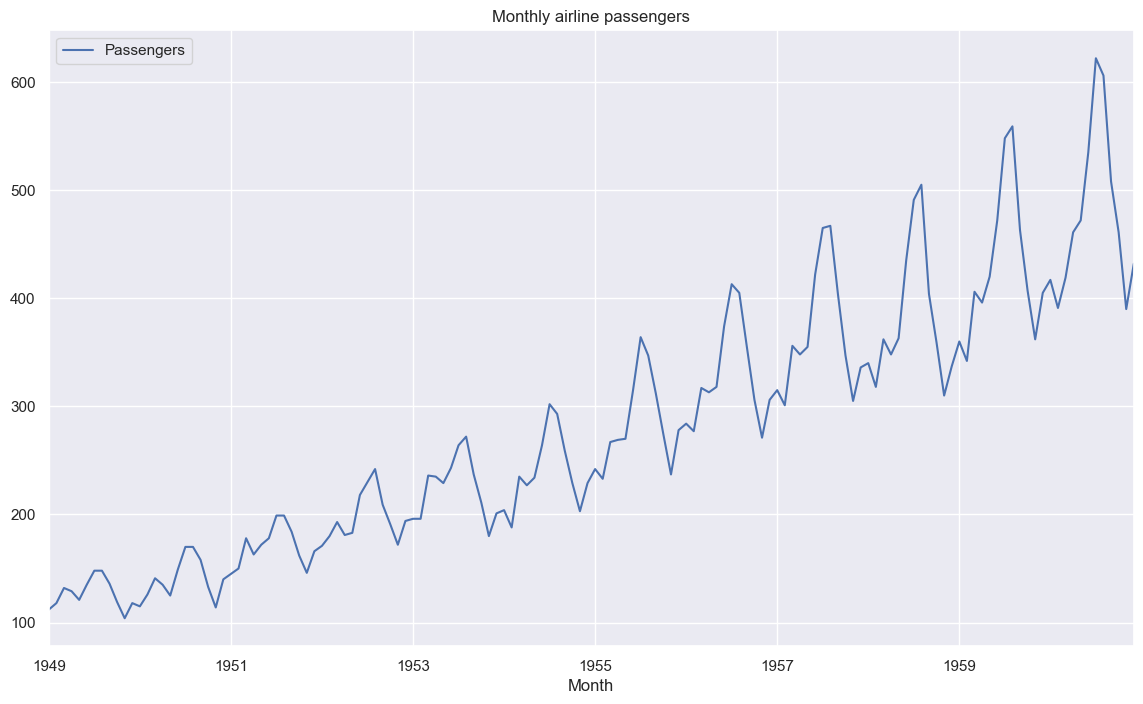

In [11]:
data.plot(figsize=(14, 8), title='Monthly airline passengers')

## 2.1 Normalize dataset

<Axes: title={'center': 'Monthly normalized airline passengers'}, xlabel='Month'>

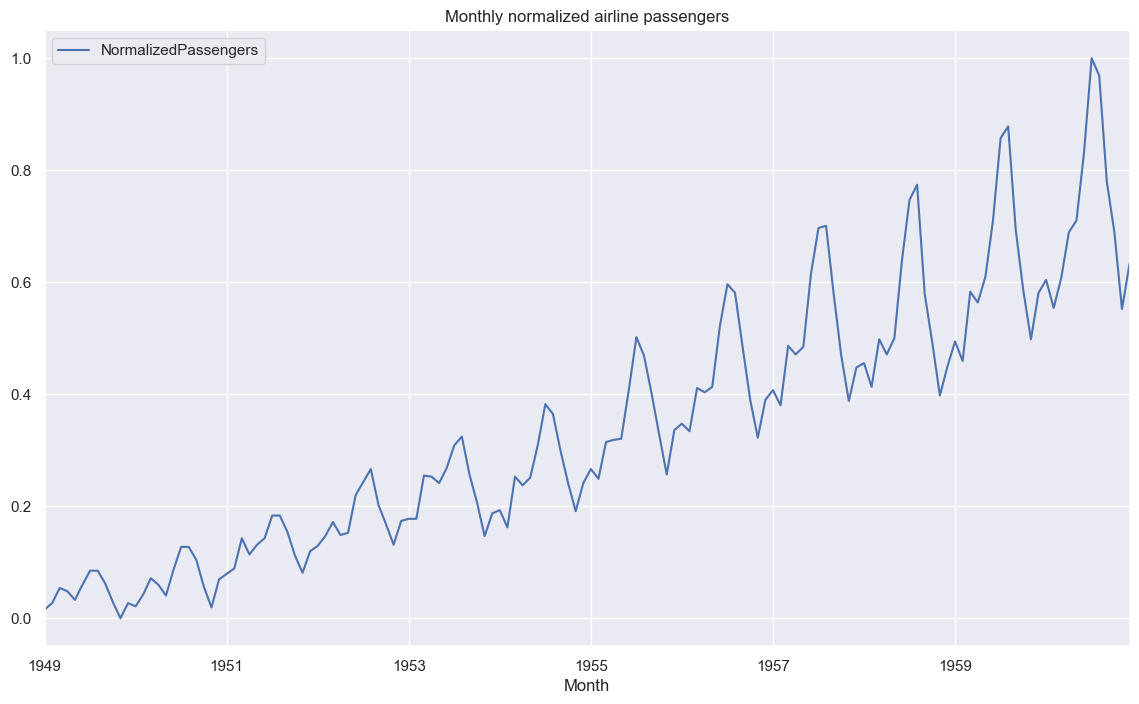

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['NormalizedPassengers'] = scaler.fit_transform(data['Passengers'].values.reshape(-1, 1)).flatten()
data[['NormalizedPassengers']].plot(figsize=(14, 8), title='Monthly normalized airline passengers')

## 2.2 Preprocess dataset

In [13]:
def create_dataset(data, timesteps=TIMESTEPS):
    """Create input and output pairs for training lstm.
    Params:
        data (pandas.DataFrame): Normalized dataset
        timesteps (int, default: TIMESTEPS): Input time length 
    Returns:
        X (numpy.array): Input for lstm
        y (numpy.array): Output for lstm
        y_date (list): Datetime of output
        start_values (list): Start valeus of each input
    """
    X, y, y_date, start_values = [], [], [], []
    
    for i in range(len(data) - timesteps):
        Xt = data.iloc[i:i+timesteps].values
        yt = data.iloc[i+timesteps]
        yt_date = data.index[i+timesteps].to_pydatetime()
        
        # Subtract a start value from each values in the timestep.
        start_value = Xt[0]
        Xt = Xt - start_value
        yt = yt - start_value
        
        X.append(Xt)
        y.append(yt)
        y_date.append(yt_date)
        start_values.append(start_value)
        
    return np.array(X), np.array(y), y_date, start_values

In [14]:
def split_train_valid_test(X, y, y_date, train_range=TRAIN_RANGE, valid_range=VALID_RANGE, test_range=TEST_RANGE):
    """Split X and y into train, valid, and test periods.
    Params:
        X (numpy.array): Input for lstm
        y (numpy.array): Output for lstm
        y_date (list): Datetime of output
        train_range (tuple): Train period
        valid_range (tuple): Validation period
        test_range (tuple): Test period
    Returns:
        X_train (pandas.DataFrame)
        X_valid (pandas.DataFrame)
        X_test (pandas.DataFrame)
        y_train (pandas.DataFrame)
        y_valid (pandas.DataFrame)
        y_test (pandas.DataFrame)
        y_date_train (list)
        y_date_valid (list)
        y_date_test (list)
    """
    train_end_idx = y_date.index(train_range[1])
    valid_end_idx = y_date.index(valid_range[1])
    
    X_train = X[:train_end_idx+1, :]
    X_valid = X[train_end_idx+1:valid_end_idx+1, :]
    X_test = X[valid_end_idx+1:, :]
    
    y_train = y[:train_end_idx+1]
    y_valid = y[train_end_idx+1:valid_end_idx+1]
    y_test = y[valid_end_idx+1:]
    
    y_date_train = y_date[:train_end_idx+1]
    y_date_valid = y_date[train_end_idx+1:valid_end_idx+1]
    y_date_test = y_date[valid_end_idx+1:]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test

In [15]:
# Create input and output pairs for training lstm.
X, y, y_date, start_values = create_dataset(data[['NormalizedPassengers']])

# Split X and y into train, valid, and test periods.
X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test = split_train_valid_test(X, y, y_date)

In [16]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(84, 12, 1) (24, 12, 1) (24, 12, 1)
(84, 1) (24, 1) (24, 1)


## 3. Create stacked GRU regression model

In [17]:
def create_model(timesteps=TIMESTEPS):
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=(timesteps, 1), name='gru_1'))  # Input timesteps months with scalar value.
    model.add(GRU(32, name='gru_2'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=0.01), metrics=['mean_absolute_error'])
    return model

In [18]:
# Create model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 12, 128)           50304     
                                                                 
 gru_2 (GRU)                 (None, 32)                15552     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 65889 (257.38 KB)
Trainable params: 65889 (257.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Callbacks of training.
es = EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=15, verbose=1, mode='auto')
fn = 'trained_model.h5'
mc = ModelCheckpoint(filepath=fn, save_best_only=True)
callbacks = [es, mc]

In [20]:
# Start training model.
fit = model.fit(
    X_train, y_train, 
    batch_size=32,
    epochs=1000, 
    verbose=2,
    validation_data=(X_valid, y_valid), 
    callbacks=callbacks)

Epoch 1/1000



3/3 - 3s - loss: 0.0024 - mean_absolute_error: 0.0392 - val_loss: 0.0033 - val_mean_absolute_error: 0.0485 - 3s/epoch - 1s/step
Epoch 2/1000
3/3 - 0s - loss: 0.0016 - mean_absolute_error: 0.0337 - val_loss: 0.0014 - val_mean_absolute_error: 0.0298 - 53ms/epoch - 18ms/step
Epoch 3/1000
3/3 - 0s - loss: 9.3130e-04 - mean_absolute_error: 0.0242 - val_loss: 0.0012 - val_mean_absolute_error: 0.0302 - 50ms/epoch - 17ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.0012 - mean_absolute_error: 0.0280 - val_loss: 0.0010 - val_mean_absolute_error: 0.0286 - 47ms/epoch - 16ms/step
Epoch 5/1000
3/3 - 0s - loss: 9.4454e-04 - mean_absolute_error: 0.0253 - val_loss: 0.0011 - val_mean_absolute_error: 0.0269 - 41ms/epoch - 14ms/step
Epoch 6/1000
3/3 - 0s - loss: 8.9756e-04 - mean_absolute_error: 0.0245 - val_loss: 0.0012 - val_mean_absolute_error: 0.0261 - 42ms/epoch - 14ms/step
Epoch 7/1000
3/3 - 0s - loss: 8.5138e-04 - mean_absolute_error: 0.0238 - val_loss: 0.0011 - val_mean_absolute_error: 0.0263 - 44ms/epoc

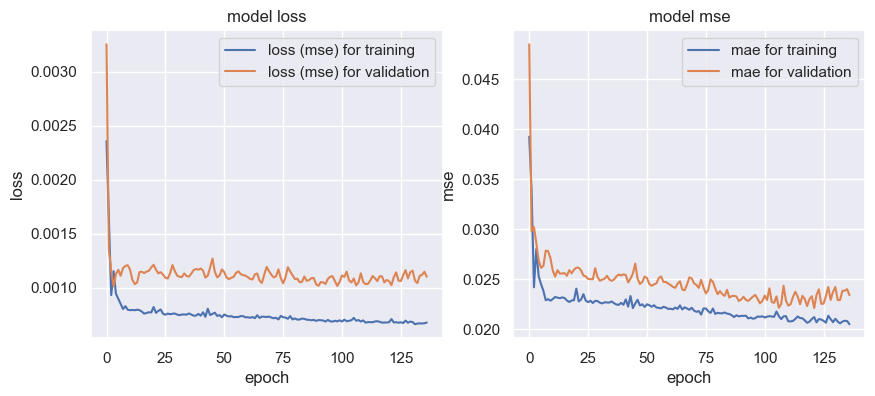

In [21]:
# Plot training history
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 4))
axL.plot(fit.history['loss'], label="loss (mse) for training")
axL.plot(fit.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(fit.history['mean_absolute_error'], label="mae for training")
axR.plot(fit.history['val_mean_absolute_error'], label="mae for validation")
axR.set_title('model mse')
axR.set_xlabel('epoch')
axR.set_ylabel('mse')
axR.legend(loc='upper right')

plt.show()

# Load best model
model = load_model(fn)

In [22]:
def evaluate_model(data, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model):
    """Evaluate trained model by rmse (root mean squared error) and mae (mean absolute error)'"""
    
    # Predict next month passengers
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_valid)
    pred_test = model.predict(X_test)
    
    # Add start_values that were subtracted when preprocessing.
    pred_train  = pred_train + start_values[:len(X_train)]
    pred_valid  = pred_valid + start_values[len(X_train):len(X_train)+len(X_valid)]
    pred_test  = pred_test + start_values[len(X_train)+len(X_valid):]
    
    # Inverse transform normalization
    pred_train = scaler.inverse_transform(pred_train).flatten()
    pred_valid = scaler.inverse_transform(pred_valid).flatten()
    pred_test = scaler.inverse_transform(pred_test).flatten()
    
    pred_df = data.copy()
    pred_df.loc[y_date_train[0]:y_date_train[-1], 'PredictionTrain'] = pred_train
    pred_df.loc[y_date_valid[0]:y_date_valid[-1], 'PredictionValid'] = pred_valid
    pred_df.loc[y_date_test[0]:y_date_test[-1], 'PredictionTest'] = pred_test
    pred_df[['Passengers', 'PredictionTrain', 'PredictionValid', 'PredictionTest']].plot(figsize=(12, 6), title='Predicted monthly airline passengers')
    fig.show()
    
    # Add start_values that were subtracted when preprocessing.
    y_train  = y_train + start_values[:len(X_train)]
    y_valid  = y_valid + start_values[len(X_train):len(X_train)+len(X_valid)]
    y_test  = y_test + start_values[len(X_train)+len(X_valid):]
    
    # Inverse transform normalization
    y_train = scaler.inverse_transform(y_train).flatten()
    y_valid = scaler.inverse_transform(y_valid).flatten()
    y_test = scaler.inverse_transform(y_test).flatten()
    
    # Evaluate prediction scores of model.
    for y, pred, mode in zip([y_train, y_valid, y_test], [pred_train, pred_valid, pred_test], ['train', 'valid', 'test']):
        rmse = np.sqrt(mean_squared_error(y, pred))
        mae = mean_absolute_error(y, pred)
        print(f'{mode} rmse: {rmse:.06f}, mae: {mae:.06f}')

1/1 [==============================] - 0s 23ms/step
train rmse: 15.971484, mae: 13.163075
valid rmse: 16.486956, mae: 14.816027
test rmse: 27.796416, mae: 24.484410


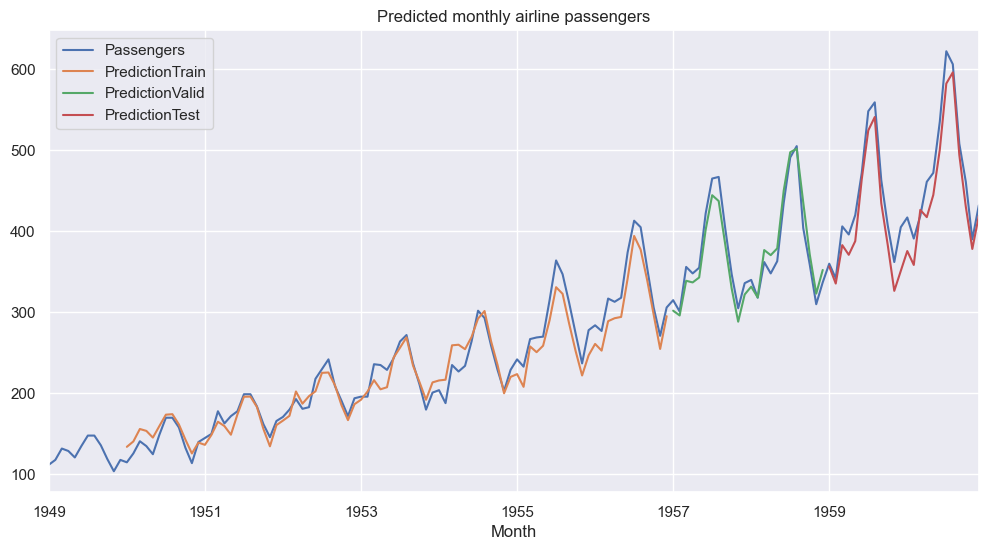

In [23]:
evaluate_model(data, scaler, X_train, X_valid, X_test, y_train, y_valid, y_test, y_date_train, y_date_valid, y_date_test, start_values, model)